In [1]:
!pip install xgboost
!pip install colorama==0.4.4
!pip install bayesian-optimization==1.4.0
import os
import pandas as pd
import numpy as np
import xgboost as xgb
import seaborn as sns
from bayes_opt import BayesianOptimization
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, roc_auc_score
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Configuration

In [62]:
# Config for the XG Boost Testing

# Where You Store the folder
Folder_Path = "C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Result"

# TimeFrame List & Included Test Currencies
tf_list = ["1M", "3M"]
curr_list = ["USD", "JPY", "GBP", "CHF","AUD", "CAD", "NZD", "NOK", "SEK", "EUR"]
exp_return_threshold = 0 # When exp.return > threshold -> Classified as 1

# ML Metrics - Use as a *kwargs to initialize ML Variable in XGBoost Classifier
model_training_parameters = {
    'learning_rate': 0.2, 
    'gamma': 0.2, 
    'reg_alpha': 0.1,
    'objective': 'binary:logistic',
    'random_state': 4010,
}

# Additional Choices
default_threshold = 0
activate_search_threshold = False
predict_direction = "PPP" # PPP/IRP
drop_fe_list = ["start_date", "end_date", "realized_spot","initial_spot", "expected_spot", "expected_ret", "spot_error_pct"] # Initial Spots, Realized Spots, You may drop as many as you like (Sample Columns is as below)
time_lag = 2 # Will loop through shift 1, 2, ....(time_lag) as user inputs
time_lag_dict = {"1M":5, "3M":1}
predict_period_after = 1 # Use latest data to predict whether label after kth period will rise.
exp_var_thres = 1 # threshold for selecting PCs based on the amount of variance explained
pca_by_feature = True #flag control on pca target
non_pca_feature = False
col_label = 'Fea_PCA'

In [41]:
# Variable Adjustment

# Generated cross product of currency list
curr_pair_1 = curr_list
curr_pair_2 = curr_list
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

# predict_direction - Later Implementation
# dir_from = predict_direction.split('-')[0]
# dir_to = predict_direction.split('-')[1]

In [42]:
#reading treasury rate

treasury_dict = {}
G_10 = curr_list
Maturity = tf_list

for currency in G_10:
    for maturity in Maturity:
        
        if currency == 'USD':
            ticker = 'USGG' + maturity + ' Index'
        else:
            ticker = 'GT'+ currency + maturity + ' Govt'
        try:
            treasury_data_df = pd.read_csv('C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Treasury Rate\\' 
                                        + ticker + '.csv', header = 1, index_col = 0)
            treasury_dict[currency+'_'+maturity] = treasury_data_df
        except:
            treasury_dict[currency+'_'+maturity] = None


# Predefined function for later step

In [43]:
def feature_engine(result_df, time_lag):
    req_col = result_df.columns
    for col in req_col:
        if col == "label":
            continue
        for i in range(1, time_lag + 1):
            result_df[f"{col}_shift{i}"] = result_df[col].shift(i)
    return result_df

def label_result(result_df, threshold = default_threshold):
    # Here you can add any label as you want...
    result_df["label"] = np.where(result_df["realized_ret"] > threshold, 1, 0)
    result_df["label"] = result_df["label"].shift(-predict_period_after)
    
    return result_df

def get_best_params(result_df):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y)
    # Optimize the machine learning parameter
    # print(X_train, y_train)
    def xgb_cv(learning_rate, max_depth):
        params = {'learning_rate': learning_rate, 'max_depth': int(max_depth), 'objective': 'binary:logistic'}
        cv_result = xgb.XGBClassifier(**params).fit(X_train, y_train).predict_proba(X_test)[:,1]
        return f1_score(y_test, (cv_result > 0.5).astype(int))
    # Set up the Bayesian optimizer
    pbounds = {'learning_rate': (0.01, 1.0), 'max_depth': (1, 10)}
    optimizer = BayesianOptimization(f=xgb_cv, pbounds=pbounds, random_state=42)

    # Run the optimization loop
    optimizer.maximize(init_points=5, n_iter=10)
    best_params = optimizer.max['params']
    best_params["max_depth"] = int(best_params["max_depth"])
    return best_params

def get_best_classification(result_df):
    result_df = result_df.dropna()
    
    X = result_df
    Y = np.where(result_df["realized_ret"] > default_threshold, 1, 0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y)

    def optimize_cf(threshold):
        param = {'threshold': threshold}
        return f1_score(y_train, (X_train["realized_ret"] > threshold).astype(int))
    pbounds = {'threshold': (-0.005, 0.005)}
    
    optimizer = BayesianOptimization(f=optimize_cf, pbounds=pbounds, random_state=42)
    optimizer.maximize(init_points=5, n_iter=10)
    
    results = optimizer.res
    filtered_results = [result for result in results if result['target'] != 1.0]
    best_params = max(filtered_results, key=lambda x: x['target'])['params']["threshold"]
    # best_params = optimizer.max['params']
    return best_params

def trainXGModel(result_df, best_params):
    result_df = result_df.dropna()
    # set training parameters and label & split the testing set.
    X = result_df.drop(columns = ["label"])
    Y = result_df["label"]
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, shuffle = False)
    
    # Fit the model
    model = xgb.XGBClassifier(**model_training_parameters)
    # model = xgb.XGBClassifier(**best_params)
    model.fit(X_train, y_train)
    
    # Get the feature importance object
    tmp_df = pd.DataFrame(model.feature_importances_.reshape(1, -1), columns=X.columns)
    obj = tmp_df.to_dict(orient='records')[0]
    
    # Predict the model 
    y_pred = pd.DataFrame(model.predict(X_test[:-1]), index=y_test.index[1:])
    accuracy = accuracy_score(y_test[:-1], y_pred)
    
    return (accuracy, obj, y_pred)

In [103]:
result_df.index = result_df["end_date"]
#labelling
result_df = label_result(result_df)
# 2.1 Drop unnecessary columns
result_df = result_df.drop(columns=drop_fe_list)

In [104]:
result_df = feature_engine(result_df, time_lag)
result_df = result_df.dropna(axis = 0)

In [105]:
result_df = result_df.dropna()
# set training parameters and label & split the testing set.
X = result_df.drop(columns = ["label"])
Y = result_df["label"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

In [111]:
model = xgb.XGBClassifier(**model_training_parameters)

In [44]:
#define a PCA PC selction function
def pca_reduction(result_df, exp_var = 0.95):
    features = result_df.columns
    features = features.drop('label')
    x = result_df.loc[:,features].values
    y = result_df.loc[:,['label']]
    x = StandardScaler().fit_transform(x)
    pca = PCA(random_state = 4010)
    principalComponents = pca.fit_transform(x)
    pc_df = pd.DataFrame(data = principalComponents)
    num_pc_selected = sum(np.cumsum(pca.explained_variance_)/sum(pca.explained_variance_) < exp_var) + 1
    trunc_pd_df = pc_df[pc_df.columns[:num_pc_selected]]
    trunc_pd_df.index = result_df.index
    trunc_pd_df = pd.concat([trunc_pd_df, result_df['label']], axis = 1)
    return trunc_pd_df

In [45]:
def pca_reduction_by_feature(result_df, exp_var = 0.95):
    pc_df = pd.DataFrame()
    pc_df.index = result_df.index
    for feature in result_df.columns:
        if feature == 'label':
            continue
        feature_df = pd.DataFrame(result_df.loc[:,feature])
        feature_df.index = result_df.index
        feature_df = feature_engine(feature_df, time_lag)
        feature_df.dropna(inplace = True)
        feature_df = pd.concat([feature_df, result_df['label']], axis = 1)
        feature_df.dropna(inplace = True)
        feature_df = pca_reduction(feature_df, exp_var = exp_var)
        feature_df.drop(columns = 'label', inplace = True)
        colname = []
        for i in range(len(feature_df.columns)):
            colname.append(f'{feature}_{i}')
        feature_df.columns = colname
        pc_df = pd.concat([pc_df, feature_df], axis = 1)
        pc_df.dropna(inplace = True)
    pc_df['label'] = result_df['label']
    return pc_df

In [40]:
c1 = 'USD'
c2 = 'JPY'
tf = '3M'
predict_direction = 'PPP'
result_df = pd.read_csv(f'{Folder_Path}\\{predict_direction}\\{c1 + c2}\\Data Details\\{tf}.csv', index_col=0)
result_df.index = result_df["end_date"]
result_df.index = pd.to_datetime(result_df.index)

tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c1}.csv', index_col=0, header = 1)
tmp.index = pd.to_datetime(tmp.index)
result_df['base_econ'] = tmp["Last_Price"].resample(tf).last()

tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c2}.csv', index_col=0, header = 1)
tmp.index = pd.to_datetime(tmp.index)
result_df['pricing_econ'] = tmp["Last_Price"].resample(tf).last()
result_df.index = result_df["end_date"]
#labelling
result_df = label_result(result_df)
# 2.1 Drop unnecessary columns
result_df = result_df.drop(columns=drop_fe_list)

In [42]:
features = result_df.columns
features = features.drop('label')
x = result_df.loc[:,features].values
y = result_df.loc[:,['label']]
x = StandardScaler().fit_transform(x)
pca = PCA()
principalComponents = pca.fit_transform(x)
pc_df = pd.DataFrame(data = principalComponents)

In [173]:
result_df = feature_engine(result_df, time_lag)
result_df = result_df.dropna(axis = 0)
result_df = pca_reduction(result_df, exp_var = exp_var_thres)

In [174]:
result_df

,0,1,2,3,4,5,6,label
end_date,,,,,,,,
1990-04-30,1.793571,0.959911,-2.264296,-0.321729,2.268120,0.093019,0.624483,0.0
1990-07-31,-1.883487,0.259212,-0.725100,-0.556219,-1.226291,-2.417200,-0.174233,0.0
1990-10-31,2.390003,1.080571,1.840289,-2.456535,1.074900,-1.539618,0.272200,1.0
1991-01-31,-0.935742,0.575717,-0.505248,-2.066429,3.325778,-0.720043,0.317183,1.0
1991-04-30,0.741567,-0.566736,-1.174781,-0.132961,1.779210,-0.819239,-0.646832,0.0
...,...,...,...,...,...,...,...,...
2021-10-31,-0.623326,3.080978,0.199346,0.397011,0.141644,-0.791862,-0.726863,1.0
2022-01-31,0.945617,3.275444,-1.132198,-0.611343,-0.289134,-0.527403,0.806288,1.0
2022-04-30,0.835185,2.219336,-1.436427,0.823711,1.435513,0.208235,-0.425891,1.0


In [175]:
accuracy, fe_obj, y_pred = trainXGModel(result_df, [])

In [177]:
accuracy

0.5384615384615384

In [179]:
y_pred.replace(0, -1, inplace = True)
y_test_ret_df = result_df['realized_ret'].loc[y_pred.index]
avg_gain = np.mean(abs(y_test_ret_df[(np.sign(y_test_ret_df) == y_pred[0]).tolist()]))
avg_lose = np.mean(abs(y_test_ret_df[(np.sign(y_test_ret_df) != y_pred[0]).tolist()]))

KeyError: 'realized_ret'

# Main Logic 

In [46]:
Top_Five_Importance_1M_df = pd.DataFrame()
Pair_accuracy_1M_df = pd.DataFrame()
Gain_Loss_Ratio_1M_df = pd.DataFrame()

Top_Five_Importance_3M_df = pd.DataFrame()
Pair_accuracy_3M_df = pd.DataFrame()
Gain_Loss_Ratio_3M_df = pd.DataFrame()

In [63]:
gen = ((x, y) for x in curr_pair_1 for y in curr_pair_2 if x != y)

accuracy_df = pd.DataFrame()
accuracy_df.index = tf_list
feature_importance_df = pd.DataFrame()
feature_importance_df.index = tf_list
gain_loss_df = pd.DataFrame()
gain_loss_df.index = tf_list

for c1, c2 in gen:
    across_pair_df_1M = pd.DataFrame()
    across_pair_df_3M = pd.DataFrame()
    
    acc_ls = []
    fe_importance_ls = []
    gain_loss_ls = []
    
    for tf in tf_list:
        time_lag = time_lag_dict[tf]
        try:
            # 1. Access file and create df
            
            result_df = pd.read_csv(f'{Folder_Path}\\{predict_direction}\\{c1 + c2}\\Data Details\\{tf}.csv', index_col=0)
            result_df.index = result_df["end_date"]
            
            if predict_direction == "PPP":
                result_df.index = pd.to_datetime(result_df.index)

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c1}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['base_econ'] = tmp["Last_Price"].resample(tf).last()

                tmp = pd.read_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_03_08_FX_Parity\\CUQTS-FX-Parity-Research-Source-Code\\CUQTS_FXParity-main\\Data\\CPI\\{c2}.csv', index_col=0, header = 1)
                tmp.index = pd.to_datetime(tmp.index)
                result_df['pricing_econ'] = tmp["Last_Price"].resample(tf).last()
                
            else:
                tmp = treasury_dict[c1+'_'+tf]
                result_df['base_econ'] = tmp["Last_Price"].loc[result_df['start_date']]

                tmp = treasury_dict[c2+'_'+tf]
                result_df['pricing_econ'] = tmp["Last_Price"].loc[result_df['start_date']]


            # tmp = pd.read_csv(f'C:/Users/johnn/Downloads/Currency_Data/{c1 + c2}.csv', index_col=0)
            # tmp.index = pd.to_datetime(tmp.index)
            # result_df[c1 + c2] = tmp["Last_Price"].resample(tf).last()
            
            result_df.index = result_df["end_date"]
            #labelling
            result_df = label_result(result_df)
            # 2.1 Drop unnecessary columns
            result_df = result_df.drop(columns=drop_fe_list)
            
            if not pca_by_feature:
                # 2.2 Feature Engineering
                Input_df = feature_engine(result_df, time_lag)
                Input_df = Input_df.dropna(axis = 0)
                if not non_pca_feature:
                    #doing PCA reduction
                    Input_df = pca_reduction(Input_df, exp_var = exp_var_thres)
            else:
                Input_df = pca_reduction_by_feature(result_df, exp_var = exp_var_thres)
            
            # print(result_df, threshold)
            # 3. Train & Test Model
            print(c1, c2)
            best_params = get_best_params(Input_df) # Train the best ML Metrics using Bayesian Search
            accuracy, fe_obj, y_pred = trainXGModel(Input_df, best_params)
            
            #extracting the gain and loss ratio
            y_pred.replace(0, -1, inplace = True)
            y_test_ret_df = result_df['realized_ret'].loc[y_pred.index]
            avg_gain = np.mean(abs(y_test_ret_df[(np.sign(y_test_ret_df) == y_pred[0]).tolist()]))
            avg_lose = np.mean(abs(y_test_ret_df[(np.sign(y_test_ret_df) != y_pred[0]).tolist()]))
            
            
            y_pred.to_csv(f"C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_Prediction\\{predict_direction}_{c1+c2}_{tf}_shift{predict_period_after}.csv")
            # 4. Append the objects
            acc_ls.append(accuracy)
            fe_importance_ls.append(fe_obj)
            gain_loss_ls.append(avg_gain/avg_lose)
            
            # 5. Concat all the same tf obj
            concatenated_df = pd.concat([result_df, eval(f"across_pair_df_{tf}")])
            globals()[f"across_pair_df_{tf}"] = concatenated_df
        except:
            acc_ls.append(np.NaN)
            fe_importance_ls.append(np.NaN)
            gain_loss_ls.append(np.NaN)
            
    accuracy_df[c1 + c2] = acc_ls
    feature_importance_df[c1 + c2] = fe_importance_ls
    gain_loss_df[c1 + c2] = gain_loss_ls

USD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.5       | 0.3808    | 9.556     |
| 2         | 0.5347    | 0.7347    | 6.388     |
| 3         | 0.4694    | 0.1645    | 2.404     |
| 4         | 0.4906    | 0.0675    | 8.796     |
| 5         | 0.4444    | 0.6051    | 7.373     |
| 6         | 0.4694    | 0.7911    | 6.389     |
| 7         | 0.4948    | 0.8302    | 3.702     |
| 8         | 0.551     | 0.1103    | 5.695     |
| 9         | 0.5       | 0.01559   | 5.174     |
| 10        | 0.5263    | 0.6709    | 6.78      |
| 11        | 0.4808    | 0.04215   | 2.937     |
| 12        | 0.46      | 0.4474    | 8.419     |
| 13        | 0.52      | 0.02843   | 4.945     |
| 14        | 0.52      | 0.4012    | 5.386     |
| 15        | 0.551     | 0.6933    | 2.102     |
USD JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.6286    | 0.3808  

| 15        | 0.5161    | 0.6933    | 2.102     |
USD NOK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.5253    | 0.3808    | 9.556     |
| 2         | 0.5385    | 0.7347    | 6.388     |
| 3         | 0.5185    | 0.1645    | 2.404     |
| 4         | 0.5143    | 0.0675    | 8.796     |
| 5         | 0.5818    | 0.6051    | 7.373     |
| 6         | 0.5421    | 0.6555    | 7.373     |
| 7         | 0.5192    | 0.6019    | 7.373     |
| 8         | 0.5556    | 0.1103    | 5.695     |
| 9         | 0.537     | 0.01559   | 5.174     |
| 10        | 0.5243    | 0.6709    | 6.78      |
| 11        | 0.5273    | 0.04215   | 2.937     |
| 12        | 0.5421    | 0.4474    | 8.419     |
| 13        | 0.5664    | 0.02843   | 4.945     |
| 14        | 0.5192    | 0.4012    | 5.386     |
| 15        | 0.5094    | 0.6933    | 2.102     |
USD NOK
|   iter    |  target   | learni... | max_depth |
----------------------------------

| 14        | 0.4598    | 0.9891    | 4.253     |
| 15        | 0.5116    | 0.01085   | 7.503     |
JPY CHF
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.2963    | 0.3808    | 9.556     |
| 2         | 0.4       | 0.7347    | 6.388     |
| 3         | 0.4444    | 0.1645    | 2.404     |
| 4         | 0.32      | 0.0675    | 8.796     |
| 5         | 0.3077    | 0.6051    | 7.373     |
| 6         | 0.2963    | 0.261     | 3.077     |
| 7         | 0.2963    | 0.8302    | 3.702     |
| 8         | 0.2308    | 0.1103    | 5.695     |
| 9         | 0.25      | 0.01559   | 5.174     |
| 10        | 0.4615    | 0.1254    | 2.139     |
| 11        | 0.4828    | 0.6598    | 2.029     |
| 12        | 0.6207    | 0.6898    | 1.265     |
| 13        | 0.5185    | 0.1767    | 1.0       |
| 14        | 0.5333    | 0.9887    | 1.025     |
| 15        | 0.5333    | 0.9896    | 1.495     |
JPY NOK
|   iter    |  target   | learni..

| 13        | 0.449     | 0.9985    | 7.725     |
| 14        | 0.52      | 0.8298    | 7.203     |
| 15        | 0.4948    | 0.4145    | 6.56      |
GBP JPY
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.4828    | 0.3808    | 9.556     |
| 2         | 0.5161    | 0.7347    | 6.388     |
| 3         | 0.4667    | 0.1645    | 2.404     |
| 4         | 0.4828    | 0.0675    | 8.796     |
| 5         | 0.5625    | 0.6051    | 7.373     |
| 6         | 0.6471    | 0.01      | 7.224     |
| 7         | 0.4516    | 0.04068   | 7.168     |
| 8         | 0.4667    | 0.1103    | 5.695     |
| 9         | 0.4375    | 0.01559   | 5.174     |
| 10        | 0.6452    | 0.6709    | 6.78      |
| 11        | 0.4       | 0.04215   | 2.937     |
| 12        | 0.4       | 0.4474    | 8.419     |
| 13        | 0.5625    | 0.02843   | 4.945     |
| 14        | 0.4828    | 0.4012    | 5.386     |
| 15        | 0.5806    | 0.6933    | 2.10

| 12        | 0.4835    | 0.4474    | 8.419     |
| 13        | 0.321     | 0.02843   | 4.945     |
| 14        | 0.4096    | 0.4012    | 5.386     |
| 15        | 0.4368    | 0.6933    | 2.102     |
GBP SEK
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.5143    | 0.3808    | 9.556     |
| 2         | 0.5143    | 0.7347    | 6.388     |
| 3         | 0.5641    | 0.1645    | 2.404     |
| 4         | 0.4865    | 0.0675    | 8.796     |
| 5         | 0.4444    | 0.6051    | 7.373     |
| 6         | 0.5263    | 0.6762    | 5.777     |
| 7         | 0.5143    | 0.3419    | 3.368     |
| 8         | 0.3889    | 0.028     | 1.665     |
| 9         | 0.4324    | 0.01559   | 5.174     |
| 10        | 0.5405    | 0.1485    | 2.495     |
| 11        | 0.5263    | 0.3802    | 2.331     |
| 12        | 0.4865    | 0.02178   | 2.25      |
| 13        | 0.5263    | 0.3799    | 2.567     |
| 14        | 0.5405    | 0.1679    | 2.41

| 11        | 0.4516    | 0.04215   | 2.937     |
| 12        | 0.4       | 0.4474    | 8.419     |
| 13        | 0.4       | 0.02843   | 4.945     |
| 14        | 0.5       | 0.4012    | 5.386     |
| 15        | 0.4516    | 0.6933    | 2.102     |
SEK CHF
|   iter    |  target   | learni... | max_depth |
-------------------------------------------------
| 1         | 0.4952    | 0.3808    | 9.556     |
| 2         | 0.4554    | 0.7347    | 6.388     |
| 3         | 0.4752    | 0.1645    | 2.404     |
| 4         | 0.4681    | 0.0675    | 8.796     |
| 5         | 0.4952    | 0.6051    | 7.373     |
| 6         | 0.5143    | 0.6762    | 5.777     |
| 7         | 0.4815    | 0.8302    | 3.702     |
| 8         | 0.4902    | 0.1103    | 5.695     |
| 9         | 0.4583    | 0.01559   | 5.174     |
| 10        | 0.4706    | 0.6709    | 6.78      |
| 11        | 0.4808    | 0.5268    | 5.733     |
| 12        | 0.5234    | 0.4474    | 8.419     |
| 13        | 0.4681    | 0.02843   | 4.94

| 9         | 0.5316    | 0.8221    | 6.056     |
| 10        | 0.48      | 0.9571    | 5.765     |
| 11        | 0.4691    | 0.9745    | 6.4       |
| 12        | 0.5316    | 0.4474    | 8.419     |
| 13        | 0.4211    | 0.6683    | 6.221     |
| 14        | 0.5063    | 0.7315    | 6.377     |
| 15        | 0.4474    | 0.6933    | 2.102     |


# General Insight

<AxesSubplot:>

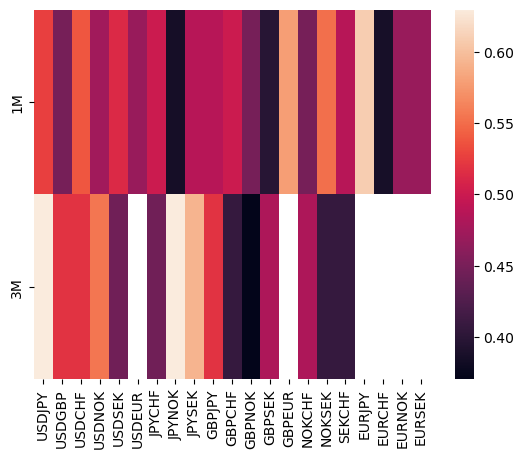

In [146]:
sns.heatmap(accuracy_df.dropna(axis=1, how='all'))

In [64]:
feature_importance_df['USDJPY'].loc['1M']

{'spread_0': 0.0628751814365387,
 'spread_1': 0.02527468092739582,
 'spread_2': 0.05439790338277817,
 'spread_3': 0.03892119973897934,
 'spread_4': 0.03764544054865837,
 'spread_5': 0.029025474563241005,
 'realized_ret_0': 0.0415768176317215,
 'realized_ret_1': 0.042378492653369904,
 'realized_ret_2': 0.057238850742578506,
 'realized_ret_3': 0.03664860874414444,
 'realized_ret_4': 0.04326097294688225,
 'realized_ret_5': 0.05594315007328987,
 'base_econ_0': 0.048494644463062286,
 'base_econ_1': 0.031227964907884598,
 'base_econ_2': 0.04484628140926361,
 'base_econ_3': 0.03648646920919418,
 'base_econ_4': 0.05015844479203224,
 'base_econ_5': 0.030246809124946594,
 'pricing_econ_0': 0.04189284145832062,
 'pricing_econ_1': 0.03791230171918869,
 'pricing_econ_2': 0.04237722232937813,
 'pricing_econ_3': 0.039349574595689774,
 'pricing_econ_4': 0.03498983383178711,
 'pricing_econ_5': 0.03683079034090042}

In [161]:
Input_df

,spread_0,spread_1,realized_ret_0,realized_ret_1,base_econ_0,base_econ_1,pricing_econ_0,pricing_econ_1,label
end_date,,,,,,,,,
2009-01-26,0.062024,-1.279347,2.939399,0.577946,4.262052,0.791511,4.012104,1.658682,1.0
2009-04-20,-0.054412,1.461960,3.341109,-0.048186,2.515204,0.035951,0.655159,0.857462,0.0
2009-07-13,-2.299841,0.844434,1.142215,-2.028833,1.669628,0.129094,-0.210093,0.000332,0.0
2009-10-05,-2.562741,-0.523539,-2.192334,-1.298851,1.244524,-0.158332,-0.204708,-0.010527,1.0
2009-12-28,-1.918592,-0.060598,-1.389812,2.036566,1.159729,-0.178042,-0.142380,-0.061907,0.0
2010-03-22,-1.726821,-0.070830,-1.204965,-1.802660,1.062434,-0.130149,-0.098650,-0.029006,0.0
2010-06-14,-1.533547,-0.061734,-1.734252,1.221874,0.905950,-0.083870,-0.019195,-0.101162,0.0
2010-09-06,-1.237801,-0.172965,-1.107921,-0.578380,0.992959,-0.324786,0.278260,-0.296442,0.0
2010-11-29,-0.958191,-0.044857,-1.136378,0.534783,1.421560,-0.504475,1.351252,-1.037365,0.0


In [17]:
fe_importance_ls

[nan,
 {0: 0.22434760630130768,
  1: 0.20803673565387726,
  2: 0.04289855435490608,
  3: 0.21016615629196167,
  4: 0.08439474552869797,
  5: 0.07095565646886826,
  6: 0.09447350353002548,
  7: 0.06472707539796829}]

In [65]:
Pair_accuracy_1M_df[col_label] = accuracy_df.T["1M"]
Pair_accuracy_3M_df[col_label] = accuracy_df.T["3M"]

In [66]:
Gain_Loss_Ratio_1M_df[col_label] = gain_loss_df.T["1M"]
Gain_Loss_Ratio_3M_df[col_label] = gain_loss_df.T["3M"]

# Aggregate Feature Importance

In [67]:
tmp_obj = {}
restruc_df = pd.DataFrame()

# Flatten each values in df -> Append the Array 
for value in feature_importance_df.values.flatten():
    if type(value) != type(tmp_obj):
        continue
    for k, v in value.items():
        if k not in tmp_obj:
            tmp_obj[k] = []
        tmp_obj[k].append(v)
        

feature_list = [k for k, v in tmp_obj.items()]
iterables = [tf_list, feature_list]

multi_index = pd.MultiIndex.from_product(iterables, names=["timeframe", "feature"])

feature_new_df = pd.DataFrame()
feature_new_df.index = multi_index

for index, row in feature_importance_df.iterrows():
    for col in feature_importance_df.columns:
        # row[col] is the objection
        if not pd.isnull(row[col]):
            for key, value in row[col].items():
                feature_new_df.loc[(index, key), col] = value
feature_new_df.dropna(how='all')

USDJPY    USDGBP    USDCHF    USDNOK    USDSEK  \
timeframe feature                                                            
1M        spread_0        0.062875  0.059252  0.053970  0.041954  0.045121   
          spread_1        0.025275  0.034890  0.052337  0.033542  0.027188   
          spread_2        0.054398  0.027451  0.032247  0.048416  0.054942   
          spread_3        0.038921  0.023386  0.027993  0.041556  0.029915   
          spread_4        0.037645  0.039208  0.030600  0.038805  0.049988   
          spread_5        0.029025  0.031698  0.041641  0.033644  0.035407   
          realized_ret_0  0.041577  0.040735  0.048618  0.037294  0.042538   
          realized_ret_1  0.042378  0.043934  0.039089  0.047590  0.028403   
          realized_ret_2  0.057239  0.044107  0.055120  0.032319  0.061416   
          realized_ret_3  0.036649  0.063356  0.046895  0.034708  0.039889   
          realized_ret_4  0.043261  0.051720  0.039645  0.051268  0.037988   
          realized_ret_5  0.055943  0.044199  0.051887  0.051645  0.042583   
          base_econ_0     0.048495  0.058765  0.057528  0.030147  0.046491   
          base_econ_1     0.031228  0.043224  0.040985  0.039578  0.048684   
          base_econ_2     0.044846  0.046193  0.035698  0.041805  0.032380   
          base_econ_3     0.036486  0.047030  0.028042  0.046699  0.048531   
          base_econ_4     0.050158  0.038203  0.041004  0.041439  0.041375   
          base_econ_5     0.030247  0.048247  0.037967  0.056833  0.047785   
          pricing_econ_0  0.041893  0.025672  0.054939  0.049019  0.035488   
          pricing_econ_1  0.037912  0.022374  0.037236  0.038898  0.035865   
          pricing_econ_2  0.042377  0.040694  0.035922  0.047639  0.044329   
          pricing_econ_3  0.039350  0.046311  0.033783  0.035898  0.022286   
          pricing_econ_4  0.034990  0.033547  0.042142  0.034531  0.043064   
          pricing_econ_5  0.036831  0.045802  0.034713  0.044775  0.058346   
3M        spread_0        0.131414  0.134730  0.132503  0.150703  0.142282   
          spread_1        0.119207  0.128672  0.120590  0.094028  0.151766   
          realized_ret_0  0.152319  0.138666  0.211816  0.097976  0.115413   
          realized_ret_1  0.153225  0.119015  0.142464  0.101782  0.123808   
          base_econ_0     0.136071  0.086431  0.094738  0.098490  0.109536   
          base_econ_1     0.064050  0.144936  0.100673  0.196177  0.143371   
          pricing_econ_0  0.108482  0.105139  0.112651  0.170004  0.077211   
          pricing_econ_1  0.135232  0.142410  0.084565  0.090840  0.136613   

                            USDEUR    JPYCHF    JPYNOK    JPYSEK    GBPJPY  \
timeframe feature                                                            
1M        spread_0        0.040871  0.057593  0.054506  0.024329  0.038093   
          spread_1        0.046957  0.029833  0.043298  0.051614  0.037382   
          spread_2        0.053676  0.025818  0.034766  0.037356  0.032606   
          spread_3        0.050982  0.043184  0.043718  0.038209  0.040815   
          spread_4        0.038021  0.027140  0.040557  0.058028  0.029565   
          spread_5        0.044415  0.042914  0.041343  0.064747  0.036758   
          realized_ret_0  0.029477  0.037247  0.039059  0.039728  0.046718   
          realized_ret_1  0.037812  0.037450  0.034096  0.031269  0.047069   
          realized_ret_2  0.042600  0.048658  0.036913  0.044444  0.026259   
          realized_ret_3  0.042789  0.045442  0.033186  0.035738  0.056324   
          realized_ret_4  0.042852  0.041495  0.049395  0.034898  0.040630   
          realized_ret_5  0.034065  0.050661  0.048598  0.056882  0.042450   
          base_econ_0     0.046507  0.029254  0.044289  0.035197  0.045124   
          base_econ_1     0.035368  0.043072  0.038245  0.033848  0.048188   
          base_econ_2     0.048101  0.035688  0.056569  0.038156  0.056447   
          base_econ_3     0.042809  0.035150  0.0

In [68]:
mean = np.mean(feature_new_df.loc[("1M", slice(None))].mean(axis = 1))
sd = np.std(feature_new_df.loc[("1M", slice(None))].mean(axis = 1))
Top_Five_Importance_1M_df[col_label]=[(x-mean)/sd for x in feature_new_df.loc[("1M", slice(None))].mean(axis = 1).sort_values(ascending= False)[:3].tolist()]

In [69]:
mean = np.mean(feature_new_df.loc[("3M", slice(None))].mean(axis = 1))
sd = np.std(feature_new_df.loc[("3M", slice(None))].mean(axis = 1))
Top_Five_Importance_3M_df[col_label]=[(x-mean)/sd for x in feature_new_df.loc[("3M", slice(None))].mean(axis = 1).sort_values(ascending= False)[:3].tolist()]

# Study

In [70]:
print(Top_Five_Importance_1M_df)
print(Top_Five_Importance_3M_df)

    Agg_Ori   Agg_PCA   Fea_PCA
0  1.715473  1.478324  2.074810
1  1.316003  1.291602  1.595979
2  0.959465  1.269856  1.315127
    Agg_Ori   Agg_PCA   Fea_PCA
0  1.858570  1.416915  1.662075
1  1.282912  1.396841  1.145897
2  0.224189  0.857887  0.469491


In [71]:
print(Pair_accuracy_1M_df)
print(Pair_accuracy_3M_df)

         Agg_Ori   Agg_PCA   Fea_PCA
USDJPY  0.415584  0.532468  0.467532
USDGBP  0.571429  0.454545  0.571429
USDCHF  0.480519  0.532468  0.454545
USDAUD       NaN       NaN       NaN
USDCAD       NaN       NaN       NaN
...          ...       ...       ...
EURAUD       NaN       NaN       NaN
EURCAD       NaN       NaN       NaN
EURNZD       NaN       NaN       NaN
EURNOK  0.460317  0.492063  0.539683
EURSEK  0.571429  0.587302  0.492063

[90 rows x 3 columns]
         Agg_Ori   Agg_PCA   Fea_PCA
USDJPY  0.653846  0.653846  0.576923
USDGBP  0.576923  0.423077  0.384615
USDCHF  0.423077  0.576923  0.346154
USDAUD       NaN       NaN       NaN
USDCAD       NaN       NaN       NaN
...          ...       ...       ...
EURAUD       NaN       NaN       NaN
EURCAD       NaN       NaN       NaN
EURNZD       NaN       NaN       NaN
EURNOK       NaN       NaN       NaN
EURSEK       NaN       NaN       NaN

[90 rows x 3 columns]


In [72]:
Pair_accuracy_1M_df.mean(axis = 0, skipna = True)

Agg_Ori    0.484694
Agg_PCA    0.492364
Fea_PCA    0.499347
dtype: float64

In [73]:
#improvement or not improvement
Pair_accuracy_1M_adj_df = Pair_accuracy_1M_df.dropna()
try:
    print(f'Agg_PCA :',{(sum(Pair_accuracy_1M_adj_df['Agg_PCA'] > Pair_accuracy_1M_adj_df['Agg_Ori']))/(sum(Pair_accuracy_1M_adj_df['Agg_PCA'] < Pair_accuracy_1M_adj_df['Agg_Ori']))})
except:
    print(f'Agg_PCA :','Inf')
print(f'Fea_PCA :' ,{(sum(Pair_accuracy_1M_adj_df['Fea_PCA'] > Pair_accuracy_1M_adj_df['Agg_Ori']))/(sum(Pair_accuracy_1M_adj_df['Fea_PCA'] < Pair_accuracy_1M_adj_df['Agg_Ori']))})

Agg_PCA : {1.3333333333333333}
Fea_PCA : {1.375}


In [74]:
Pair_accuracy_3M_df.mean(axis = 0, skipna = True)

Agg_Ori    0.497436
Agg_PCA    0.520513
Fea_PCA    0.482051
dtype: float64

In [75]:
#improvement or not improvement
#improvement or not improvement
Pair_accuracy_3M_adj_df = Pair_accuracy_3M_df.dropna()
print(f'Agg_PCA :', {(sum(Pair_accuracy_3M_adj_df['Agg_PCA'] > Pair_accuracy_3M_adj_df['Agg_Ori']))/(sum(Pair_accuracy_3M_adj_df['Agg_PCA'] < Pair_accuracy_3M_adj_df['Agg_Ori']))})
print(f'Fea_PCA :', {(sum(Pair_accuracy_3M_adj_df['Fea_PCA'] > Pair_accuracy_3M_adj_df['Agg_Ori']))/(sum(Pair_accuracy_3M_adj_df['Fea_PCA'] < Pair_accuracy_3M_adj_df['Agg_Ori']))})

Agg_PCA : {1.1666666666666667}
Fea_PCA : {0.5}


In [76]:
print(Gain_Loss_Ratio_1M_df)
print(Gain_Loss_Ratio_3M_df)

         Agg_Ori   Agg_PCA   Fea_PCA
USDJPY  0.744138  0.907305  0.753226
USDGBP  1.068553  1.051487  1.151707
USDCHF  0.943181  0.924765  1.048806
USDAUD       NaN       NaN       NaN
USDCAD       NaN       NaN       NaN
...          ...       ...       ...
EURAUD       NaN       NaN       NaN
EURCAD       NaN       NaN       NaN
EURNZD       NaN       NaN       NaN
EURNOK  1.253272  1.066653  1.317745
EURSEK  0.896575  1.139972  0.909484

[90 rows x 3 columns]
         Agg_Ori   Agg_PCA   Fea_PCA
USDJPY  0.667685  1.564779  1.069408
USDGBP  0.947958  0.724058  1.648021
USDCHF  0.934756  1.026422  1.404431
USDAUD       NaN       NaN       NaN
USDCAD       NaN       NaN       NaN
...          ...       ...       ...
EURAUD       NaN       NaN       NaN
EURCAD       NaN       NaN       NaN
EURNZD       NaN       NaN       NaN
EURNOK       NaN       NaN       NaN
EURSEK       NaN       NaN       NaN

[90 rows x 3 columns]


In [77]:
Gain_Loss_Ratio_1M_df.mean(axis=0, skipna = True)

Agg_Ori    0.976160
Agg_PCA    1.036937
Fea_PCA    1.007300
dtype: float64

In [78]:
Gain_Loss_Ratio_3M_df.mean(axis=0, skipna = True)

Agg_Ori    0.926294
Agg_PCA    1.028983
Fea_PCA    1.154292
dtype: float64

In [79]:
Top_Five_Importance_1M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Top_Three_Importance_{predict_direction}_1M.csv')
Pair_accuracy_1M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Pair_Accuracy_{predict_direction}_1M.csv')
Gain_Loss_Ratio_1M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Gain_Loss_Ratio_{predict_direction}_1M.csv')

Top_Five_Importance_3M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Top_Three_Importance_{predict_direction}_3M.csv')
Pair_accuracy_3M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Pair_Accuracy_{predict_direction}_3M.csv')
Gain_Loss_Ratio_3M_df.to_csv(f'C:\\Users\\anson\\OneDrive\\桌面\\CUQTS\\2023_04_03\\XG_Boost_PCA_Enhancement\\Gain_Loss_Ratio_{predict_direction}_3M.csv')